In [ ]:
!pip install datasets transformers evaluate tf-keras

In [1]:
import os
from transformers import TRANSFORMERS_CACHE
print(TRANSFORMERS_CACHE)
if 'HF_HOME' in os.environ:
    print(os.environ['HF_HOME'])
else:
    os.environ['HF_HOME'] = TRANSFORMERS_CACHE

C:\Users\m.dipaolo\.cache\huggingface\hub


In [18]:
from transformers import AutoModelForSequenceClassification, AutoModelForMaskedLM 
def _model_summary(model):
    for layer in model.children():
        print(layer)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("\n")
    print(model.config)
    print(f"Total params: {total_params:,}, Trainable params: {trainable_params:,}\n\n")

base_model_name = "google-bert/bert-base-cased"

#Original BERT (Masked LM):
#[Input] → [12 Transformer Layers] → [MLM Head] → Predict masked tokens
base_mlm_model = AutoModelForMaskedLM.from_pretrained(base_model_name)
print("Original BERT (Masked LM) Model Summary:")
_model_summary(base_mlm_model)

#Fine-tuned BERT (Sequence Classification):
#[Input] → [12 Transformer Layers] → [Classification Head] → 5-class output
#replaces BERT's original head with a new classification head
base_classifier_model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=5)
print("\nBERT (Sequence Classification) Model Summary:")
_model_summary(base_classifier_model)

Some weights of the model checkpoint at google-bert/bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Original BERT (Masked LM) Model Summary:
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERT (Sequence Classification) Model Summary:
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [3]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer 
base_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
base_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer

dataset = load_dataset("yelp_review_full")

def tokenize(tokenizer, examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

dataset = dataset.map(lambda x: tokenize(base_tokenizer, x), batched=True)
# save a test subset to csv
pd.DataFrame(dataset["test"][:1000]).to_csv("../03.ignore/yelp_review_full_test.csv", index=False)
#show dataset sample after tokenization
print(dataset["train"][0])

Map:   0%|          | 0/650000 [00:00<?, ? examples/s]

{'label': 4, 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.", 'input_ids': [101, 173, 1197, 119, 2284, 2953, 3272, 1917, 178, 1440, 1111, 1107, 170, 1704, 22351, 119, 1119, 112, 188, 3505, 1105, 3123, 1106, 2037, 1106, 1443, 1217, 10063, 4404, 132, 1119, 112, 188, 1579, 1113, 1159, 1107, 3195, 1117, 4420, 132, 1119, 112, 188, 6559, 1114, 170, 1499, 118, 23555, 2704, 113, 183, 9379, 114, 1134, 1139, 2153, 1138, 3716, 1106, 1143, 1110, 1304, 1696, 1107, 1692, 1380, 5940, 1105, 1128, 1444, 6059, 132, 

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="../03.ignore/yelp-review-classifier",
    report_to="none",
    eval_strategy="epoch",
    num_train_epochs=1,#ridiculously small for demo purposes: colab 3
    push_to_hub=False,
)
num_samples = 100 #ridiculously small subset for demo purposes: colab 10_000
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=dataset["train"].shuffle(seed=42).select(range(num_samples)), #ridiculously small subset for demo purposes
    eval_dataset=dataset["test"].shuffle(seed=42).select(range(num_samples)),
    compute_metrics=compute_metrics,
)
trainer.train()

c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.605766,0.240000


c:\Users\m.dipaolo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=13, training_loss=1.6276983114389272, metrics={'train_runtime': 649.8306, 'train_samples_per_second': 0.154, 'train_steps_per_second': 0.02, 'total_flos': 26311814246400.0, 'train_loss': 1.6276983114389272, 'epoch': 1.0})


### colab 10_000 samples in 3 epochs
```text  
TrainOutput(global_step=3750, training_loss=0.7398969421386719, metrics={'train_runtime': 3971.4154, 'train_samples_per_second': 7.554, 'train_steps_per_second': 0.944, 'total_flos': 7893544273920000.0, 'train_loss': 0.7398969421386719, 'epoch': 3.0})
```

In [6]:
from transformers import TRANSFORMERS_CACHE
#models--google-bert--bert-base-cased
#models--google-bert--bert-instruct-yelp-classifier
if False:
    trainer.save_model(f"{TRANSFORMERS_CACHE}/models--google-bert--bert-instruct-yelp-classifier")


In [1]:
import pandas as pd
import torch
import random
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TRANSFORMERS_CACHE
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)
base_model.to(device)
finetuned_model = AutoModelForSequenceClassification.from_pretrained(f"{TRANSFORMERS_CACHE}/models--google-bert--bert-instruct-yelp-classifier", num_labels=5)
finetuned_model.to(device)
base_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
dataset = pd.read_csv("../03.ignore/yelp_review_full_test.csv").to_dict(orient="records")
random.shuffle(dataset)

for i in range(10):    
    _review = dataset[i]['text']
    print(f"\n{_review}")
    inputs = base_tokenizer(_review, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # predictions
    base_pred = torch.argmax(base_model(**inputs).logits, dim=1).item()
    fine_tuned_pred = torch.argmax(finetuned_model(**inputs).logits, dim=1).item()
    print(f"Base: {base_pred + 1} | fine-tuned: {fine_tuned_pred + 1} | actual: {dataset[i]['label'] + 1} stars")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



REDO!\n\nI went to PF Chang's several years ago and was NOT pleased with the food that was presented to me.  \n\nMy issue: I thought I was getting Chinese food.  \n\nMy resolution: Try this restaurant again knowing that it is just reinvented American food with names of those Chinese dishes I actually like to eat.\n\nSo we returned to PF Chang's for lunch to try this American food in this caricature of a Chinese restaurant.  There were very few people in the restaurant.  The two of us were seated in the largest corner booth and left to review our menus.  When our waitress finally arrived we ordered the following items:\n\nCoca Cola\nIced Tea\nPan fried pork dumplings\nSesame chicken lunch with white rice and egg drop soup\nChangs chicken with white rice\n\nOur drinks and my soup came out immediately.  Unfortunately I was brought the wrong soup and the server had disappeared before I had a chance to say anything.  I could see her across the barren wasteland that was the dining room and 

In [13]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TRANSFORMERS_CACHE
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

finetuned_model = AutoModelForSequenceClassification.from_pretrained(
    f"{TRANSFORMERS_CACHE}/models--google-bert--bert-instruct-yelp-classifier", 
    num_labels=5
)
finetuned_model.to(device)
finetuned_model.eval()  # set to evaluation mode

# load tokenizer (unchanged from fine-tuning model)
base_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
# load test (unseen) dataset
dataset = pd.read_csv("../03.ignore/yelp_review_full_test.csv")[:100]

print(f"Evaluating on {len(dataset)} samples...")

def evaluate_model(model, tokenizer, reviews, batch_size=32):
    predictions = []
    
    with torch.no_grad():  # disable gradient computation for inference
        for i in tqdm(range(0, len(reviews), batch_size), desc="Processing review in batches"):
            batch_reviews = reviews[i:i+batch_size]
            
            # Tokenize batch
            inputs = tokenizer(
                batch_reviews, 
                return_tensors="pt", 
                padding=True, 
                truncation=True, 
                max_length=512
            )
            
            # Move to device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Get predictions
            logits = model(**inputs).logits            
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy() 
            predictions.extend(batch_preds)
    
    return np.array(predictions)  

print("\nEvaluating fine-tuned model...")
finetuned_predictions = evaluate_model(finetuned_model, base_tokenizer, dataset['text'].tolist())

# Get true labels
true_labels = dataset['label'].values

# Calculate metrics for fine-tuned model
print("\n" + "="*60)
print("FINE-TUNED MODEL RESULTS")
print("="*60)
finetuned_accuracy = accuracy_score(true_labels, finetuned_predictions)
finetuned_precision = precision_score(true_labels, finetuned_predictions, average='weighted')
finetuned_recall = recall_score(true_labels, finetuned_predictions, average='weighted')

print(f"Accuracy:  {finetuned_accuracy:.4f}")
print(f"Precision: {finetuned_precision:.4f}")
print(f"Recall:    {finetuned_recall:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(
    true_labels, 
    finetuned_predictions, 
    target_names=['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, finetuned_predictions))

Using device: cpu
Evaluating on 100 samples...

Evaluating fine-tuned model...


Processing review in batches: 100%|██████████| 4/4 [01:27<00:00, 21.77s/it]


FINE-TUNED MODEL RESULTS
Accuracy:  0.5900
Precision: 0.6039
Recall:    0.5900

Detailed Classification Report:
              precision    recall  f1-score   support

      1 star       0.67      0.67      0.67        24
     2 stars       0.54      0.58      0.56        26
     3 stars       0.36      0.38      0.37        13
     4 stars       0.76      0.57      0.65        23
     5 stars       0.59      0.71      0.65        14

    accuracy                           0.59       100
   macro avg       0.58      0.58      0.58       100
weighted avg       0.60      0.59      0.59       100

Confusion Matrix:
[[16  8  0  0  0]
 [ 6 15  5  0  0]
 [ 1  4  5  2  1]
 [ 1  0  3 13  6]
 [ 0  1  1  2 10]]


In [31]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TRANSFORMERS_CACHE
dataset = [
    {"text": "A delightful experience with a cozy atmosphere and great music.", "stars": 4},
    {"text": "The pasta was cooked perfectly and the sauce tasted fresh and rich.", "stars": 5},
    {"text": "Service was slow and the waiter seemed annoyed when we asked for water.", "stars": 2},
    {"text": "Amazing experience. The steak was juicy and the dessert unforgettable.", "stars": 5},
    {"text": "The soup was cold and lacked flavor. Not worth the price.", "stars": 2},
    {"text": "Friendly staff, cozy atmosphere, and delicious pizza. Highly recommended.", "stars": 5},
    {"text": "Mediocre food, but the location is convenient.", "stars": 3},
    {"text": "The restaurant was too noisy and the portions were very small.", "stars": 2},
    {"text": "Excellent seafood, fresh and perfectly seasoned.", "stars": 5},
    {"text": "Nothing special. Average food and service.", "stars": 3},
    {"text": "Terrible experience. My order was wrong and the staff didn’t care.", "stars": 1},
    {"text": "The sushi was fresh and beautifully presented.", "stars": 5},
    {"text": "Overpriced for what you get. The food was bland.", "stars": 2},
    {"text": "Great ambiance and friendly waiters, but the main course was overcooked.", "stars": 3},
    {"text": "Everything was perfect — the service, the food, and the atmosphere.", "stars": 5},
    {"text": "Disappointing. The burger was greasy and the fries soggy.", "stars": 1},
    {"text": "Good value for money. Tasty dishes and quick service.", "stars": 4},
    {"text": "Decent place for a casual lunch. Nothing extraordinary.", "stars": 3},
    {"text": "Horrible hygiene. Tables were dirty and cutlery wasn’t clean.", "stars": 1},
    {"text": "Lovely presentation, attentive staff, and fantastic flavors.", "stars": 5},
    {"text": "Average experience. Some dishes were good, others poorly made.", "stars": 3},
    {"text": "Highest price, lowest quality food.", "stars": 1},
    {"text": "Highest quality food, lowest price.", "stars": 5}
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []
model = AutoModelForSequenceClassification.from_pretrained(f"{TRANSFORMERS_CACHE}/models--google-bert--bert-instruct-yelp-classifier", num_labels=5)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
for item in dataset:
    inputs = tokenizer(item['text'], return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits    
    prediction = torch.argmax(logits, dim=1).item() + 1 # stars are 1-5
    results.append({
        "text": item['text'],
        "pred": prediction,
        "actual": item['stars'],
        "result": "✅" if prediction == item['stars'] else ("🟡" if abs(prediction - item['stars']) == 1 else "❌")
    })
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


                                                                     text  pred  actual result
          A delightful experience with a cozy atmosphere and great music.     4       4      ✅
      The pasta was cooked perfectly and the sauce tasted fresh and rich.     4       5      🟡
  Service was slow and the waiter seemed annoyed when we asked for water.     2       2      ✅
   Amazing experience. The steak was juicy and the dessert unforgettable.     3       5      ❌
                The soup was cold and lacked flavor. Not worth the price.     2       2      ✅
Friendly staff, cozy atmosphere, and delicious pizza. Highly recommended.     5       5      ✅
                           Mediocre food, but the location is convenient.     3       3      ✅
           The restaurant was too noisy and the portions were very small.     2       2      ✅
                         Excellent seafood, fresh and perfectly seasoned.     5       5      ✅
                               Nothing special. Av

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average absolute weight change in Layer 0 attention: 0.001579


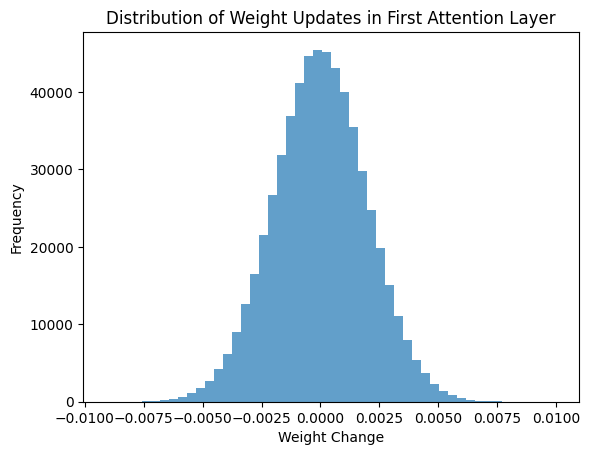

Layer 0: 0.001579
Layer 1: 0.001588
Layer 2: 0.001574
Layer 3: 0.001558
Layer 4: 0.001541
Layer 5: 0.001578
Layer 6: 0.001581
Layer 7: 0.001553
Layer 8: 0.001519
Layer 9: 0.001456
Layer 10: 0.001381
Layer 11: 0.001213


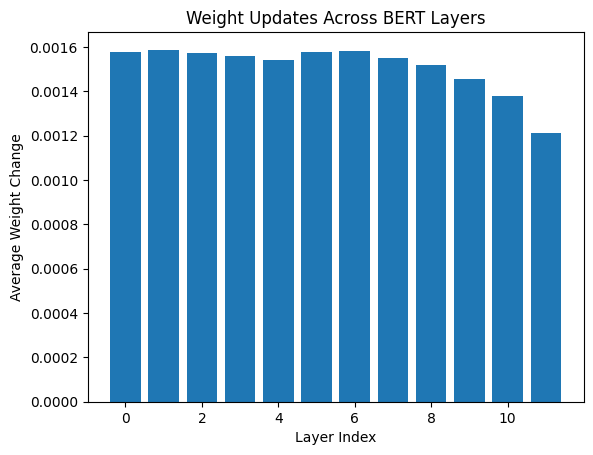

In [9]:
import torch
from transformers import AutoModelForSequenceClassification, TRANSFORMERS_CACHE
import matplotlib.pyplot as plt

# Load both models
base = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=5)
finetuned = AutoModelForSequenceClassification.from_pretrained(
    f"{TRANSFORMERS_CACHE}/models--google-bert--bert-instruct-yelp-classifier",
    num_labels=5
)

# Compare a layer's weights (e.g., first attention layer)
base_attn = base.bert.encoder.layer[0].attention.self.query.weight
finetuned_attn = finetuned.bert.encoder.layer[0].attention.self.query.weight

# Calculate difference
weight_diff = (finetuned_attn - base_attn).abs().mean().item()
print(f"Average absolute weight change in Layer 0 attention: {weight_diff:.6f}")

# Visualize change distribution
diff_flat = (finetuned_attn - base_attn).flatten().detach().numpy()
plt.hist(diff_flat, bins=50, alpha=0.7)
plt.xlabel("Weight Change")
plt.ylabel("Frequency")
plt.title("Distribution of Weight Updates in First Attention Layer")
plt.show()

# Check which layers changed most
layer_changes = []
for i in range(12):
    base_w = base.bert.encoder.layer[i].attention.self.query.weight
    fine_w = finetuned.bert.encoder.layer[i].attention.self.query.weight
    change = (fine_w - base_w).abs().mean().item()
    layer_changes.append(change)
    print(f"Layer {i}: {change:.6f}")

plt.bar(range(12), layer_changes)
plt.xlabel("Layer Index")
plt.ylabel("Average Weight Change")
plt.title("Weight Updates Across BERT Layers")
plt.show()